In [14]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
from imageio import imread

import copy
import sys

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [15]:
# Import the data
data = np.loadtxt(open('../Datasets/mnist_train.csv', 'rb'), delimiter=',')

# We only need the data
data = data[:, 1:]

# Normilize the data
dataNorm = data / np.max(data)
dataNorm = 2* dataNorm - 1

print(np.min(dataNorm), np.max(dataNorm))

# Convert to tensor
dataT = torch.tensor(dataNorm).float()

batchsize = 100

-1.0 1.0


In [17]:
# Discriminator Model
class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)

    def forward(self,x):
        x = F.leaky_relu( self.fc1(x) )
        x = F.leaky_relu( self.fc2(x) )
        x = self.out(x)
        return torch.sigmoid( x )

dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

tensor([[0.5037],
        [0.5346],
        [0.5076],
        [0.5271],
        [0.5122],
        [0.5028],
        [0.5560],
        [0.5175],
        [0.5005],
        [0.5086]], device='cuda:0', grad_fn=<SigmoidBackward0>)

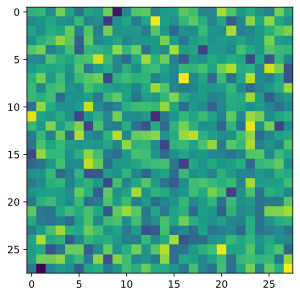

In [18]:
# Generator Model
class generatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 784)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)
        return torch.tanh(x)
    
gnet = generatorNet()
y = gnet(torch.randn(10, 64))
plt.imshow(y[0,:].cpu().detach().squeeze().view(28, 28))

In [19]:
# Loss function 
lossFun = nn.BCELoss()

# Instantiate the models and move it to the gpu
dnet = discriminatorNet().to(device=device)
gnet = generatorNet().to(device=device)

# Optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=0.0003)

In [20]:
# Model training
epochs = 1
losses = np.zeros((epochs, 2))
disDecs = np.zeros((epochs, 2))

for epoch in range(epochs):

    # Create minibatchs for REAL and FAKE images
    randIdx = torch.randint(dataT.shape[0], (batchsize,))
    real_images = dataT[randIdx, :].to(device)
    fake_images = gnet(torch.randn(batchsize, 64).to(device))

    # Labels used for real and fake images
    real_labels = torch.ones(batchsize, 1).to(device)
    fake_labels= torch.zeros(batchsize, 1).to(device)

    ### ---------------------Train the discriminator-------------------------###

    # Forward pass and loss for REAL picture
    pred_real = dnet(real_images)
    d_loss_real = lossFun(pred_real, real_labels)

    # Forward pass and loss for FAKE pictures
    pred_fake = dnet(fake_images)
    d_loss_fake = lossFun(pred_fake, fake_labels)

    # Collect losses using combined losses
    d_loss = d_loss_real + d_loss_fake
    losses[epoch, 0] = d_loss.cpu().item()
    disDecs[epoch, 0] = torch.mean((pred_real > 0.5).float()).cpu().detach()
    # Backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    ###------------------------Train the generator-------------------------###
    # Create fake images and compute loss
    fake_images = gnet(torch.randn(batchsize, 64).to(device))
    pred_fake = dnet(fake_images)

    # Compute and collect losses
    g_loss = lossFun(pred_fake, real_labels)
    losses[epoch, 1] = g_loss.cpu().item()
    disDecs[epoch, 1] = torch.mean((pred_fake > .5).float()).cpu().detach()

    # Backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    # Print out the status message
    if(epoch + 1) % 500 == 0:
        msg = f'Finished epoch {epoch + 1} / {epochs}'
        sys.stdout.write('\r' + msg)